In [1]:
import nltk
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\LAKSHMI SRI
[nltk_data]     LASYA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\LAKSHMI SRI
[nltk_data]     LASYA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\LAKSHMI SRI
[nltk_data]     LASYA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
import json
dataList = []
sentences = []
labels = []
def loadDataset(filename):
  d=[]
  with open(filename, 'r') as f:
      datastore = json.load(f)
  for item in datastore:
    sentence = item['data']
    label = item['is_sensitive']
    d.append([sentence,label])
  return d
# Loading both sensitive and non-sensitive dataset
sen=loadDataset("SensitiveDataset.json")
nonsen=loadDataset("NonSensitiveDatasetnew.json")
sen=pd.DataFrame(data=sen,columns=['sentences','labels'])
nonsen=pd.DataFrame(data=nonsen,columns=['sentences','labels'])

In [3]:
combined = pd.concat([sen, nonsen])
df = combined.sample(frac=1).reset_index(drop=True)
df.head()

,sentences,labels
0,"Harry Crown, a stylish professional hit man wi...",0
1,"Cinderella is living a dissatisfying life, hav...",0
2,Norma Selbee is a chorus girl trying to make i...,0
3,"scptest, pineapple1, scptest@aim.com, 5...",1
4,"King Morgan (Lloyd Nolan), chief pilot for W. ...",0


In [4]:
tokenized_data = [word_tokenize(sentence) for sentence in df['sentences']]
stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
punctuations.remove('@')
stop_words.update(punctuations)
stemmer = PorterStemmer()
filtered_data = [[stemmer.stem(word) for word in sentence if word.lower() not in stop_words] for sentence in tokenized_data]
l=[]
for idx, sentence in enumerate(filtered_data):
    l.append(' '.join(sentence))
df['sentences'] = l

In [5]:
df.head() 

,sentences,labels
0,harri crown stylish profession hit man pair br...,0
1,cinderella live dissatisfi life lost parent yo...,0
2,norma selbe choru girl tri make new york citi ...,0
3,scptest pineapple1 scptest @ aim.com 5797829693,1
4,king morgan lloyd nolan chief pilot w. j. brad...,0


In [6]:
df_train = df.sample(frac=.8, random_state=11)
df_test = df.drop(df_train.index)
print(df_train.shape, df_test.shape)

(25261, 2) (6315, 2)


In [7]:
y_train = df_train['labels'].values
y_test = df_test['labels'].values
y_test.shape

(6315,)

In [8]:
X_train = df_train['sentences'].values
X_test = df_test['sentences'].values

In [9]:
print(X_train)

["king henri viii 's marriag catherin aragon becom troubl produc male heir throne one surviv child mari ann 's younger sister mari boleyn marri william carey festiv thoma howard duke norfolk brother-in-law thoma boleyn plan instal boleyn 's eldest daughter ann boleyn king 's mistress hope ann bear son 'll abl improv famili 's wealth statu ann 's mother ladi elizabeth boleyn disgust plot ann eventu agre way pleas father uncl visit boleyn estat henri injur hunt accid indirectli caus ann urg scheme uncl mari nurs henri henri becom smitten mari invit court mari husband reluctantli agre awar king invit desir mari ann becom ladies-in-wait queen catherin henri send william carey abroad assign separ husband mari begin affair king find fall love ann secretli marri nobleman henri perci although alreadi betroth ladi mari talbot ann confid brother georg boleyn marriag overjoy georg proce tell mari fear ann ruin boleyn famili marri promin earl without king 's consent mari alert father uncl confront

In [10]:
#Tokenization
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

In [11]:
from gensim.models import Word2Vec
sentences = [sentence.split() for sentence in X_train]

# Train Word2Vec model
modelvec = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

#Give me a random vector to handle OOV words
modelvec.wv['<UNK>'] = np.random.randn(100)

# Create a weight matrix for words in training docs
embedding_matrix = np.zeros((len(modelvec.wv.key_to_index), modelvec.vector_size))
for i in range(len(modelvec.wv.key_to_index)):
    embedding_vector = modelvec.wv[modelvec.wv.index_to_key[i]]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [12]:
max_len=max(len(seq) for seq in X_train)
max_len

14225

In [13]:
#pad X_train and X_test
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train, padding='post', maxlen=100)
X_test_pad = pad_sequences(X_test, padding='post', maxlen=100)


In [14]:
X_train_pad.shape

(25261, 100)

In [15]:
len(modelvec.wv.key_to_index)

94124

In [16]:
from keras.regularizers import l1
from keras.constraints import max_norm
lstm_model1 = Sequential()
lstm_model1.add(Embedding(input_dim=len(modelvec.wv.key_to_index), output_dim=modelvec.vector_size, weights=[embedding_matrix], input_length=100, trainable=False))
lstm_model1.add(LSTM(400,input_shape=(100, modelvec.vector_size),kernel_regularizer=l1(0.01),kernel_constraint=max_norm(1.)))
lstm_model1.add(Dense(1, activation='sigmoid'))

lstm_model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model1.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9412400   
                                                                 
 lstm (LSTM)                 (None, 400)               801600    
                                                                 
 dense (Dense)               (None, 1)                 401       
                                                                 
Total params: 10214401 (38.96 MB)
Trainable params: 802001 (3.06 MB)
Non-trainable params: 9412400 (35.91 MB)
_________________________________________________________________


In [17]:
history = lstm_model1.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_test_pad, y_test))

Epoch 1/10


395/395 [==============================] - 369s 911ms/step - loss: 3.6758 - accuracy: 0.8744 - val_loss: 0.9423 - val_accuracy: 0.5021
Epoch 2/10
395/395 [==============================] - 302s 766ms/step - loss: 1.2790 - accuracy: 0.6939 - val_loss: 1.7235 - val_accuracy: 0.9124
Epoch 3/10
395/395 [==============================] - 259s 657ms/step - loss: 0.4859 - accuracy: 0.9774 - val_loss: 0.2383 - val_accuracy: 0.9959
Epoch 4/10
395/395 [==============================] - 258s 654ms/step - loss: 0.2903 - accuracy: 0.9932 - val_loss: 0.2121 - val_accuracy: 0.9945
Epoch 5/10
395/395 [==============================] - 276s 699ms/step - loss: 0.2181 - accuracy: 0.9968 - val_loss: 0.2100 - val_accuracy: 0.9951
Epoch 6/10
395/395 [==============================] - 299s 757ms/step - loss: 0.3448 - accuracy: 0.9880 - val_loss: 0.4004 - val_accuracy: 0.8923
Epoch 7/10
395/395 [==============================] - 337s 853ms/step - loss: 0.2800 - accuracy: 0.9929 - val_loss: 0.2760

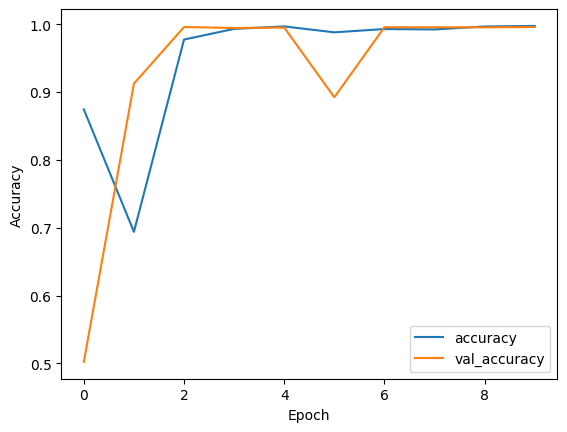

In [18]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy') 
plt.legend(loc='lower right')

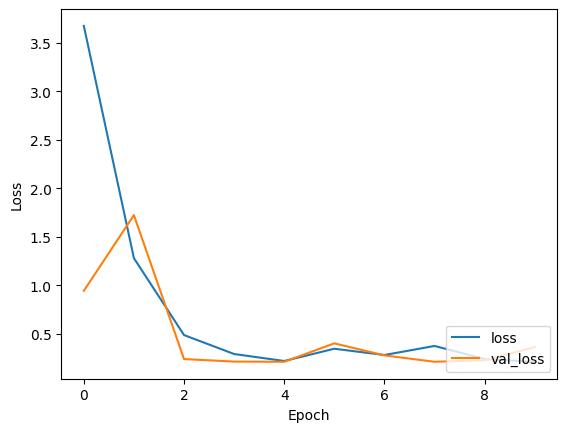

In [19]:
#make a graph for loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')


In [31]:
test_loss, test_acc = lstm_model1.evaluate(X_test_pad, y_test, verbose=2)   

198/198 - 8s - loss: 0.3621 - accuracy: 0.9959 - 8s/epoch - 42ms/step


In [33]:
test = ['Name', 'Age', 'Gender', 'Blood Type', 'Medical Condition',
       'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider',
       'Billing Amount', 'Room Number', 'Admission Type', 'Discharge Date',
       'Medication', 'Test Results',"My social security number is 123-45-6789.",
"My credit card number is 1234 5678 9012 3456.",
"My email address is john.doe@example.com.",
"My phone number is (123) 456-7890.",
"I live at 123 Main St, Anytown, USA.",
"I love to play soccer on the weekends.",
"My favorite color is blue.",
"I enjoy reading books and listening to music.",
"The weather is really nice today.",
"I have a pet dog named Rover.",]
for i in test:
    seq = tokenizer.texts_to_sequences([i])
    pad = pad_sequences(seq, maxlen=100, padding='post')
    pred = lstm_model1.predict(pad)
    if pred > 0.5:
        print(i, 'Sensitive')
    else:
        print(i, 'Non-sensitive')

1/1 [==============================] - 0s 32ms/step
Name Sensitive
1/1 [==============================] - 0s 30ms/step
Age Sensitive
1/1 [==============================] - 0s 97ms/step
Gender Sensitive
1/1 [==============================] - 0s 31ms/step
Blood Type Sensitive
1/1 [==============================] - 0s 31ms/step
Medical Condition Sensitive
1/1 [==============================] - 0s 29ms/step
Date of Admission Sensitive
1/1 [==============================] - 0s 31ms/step
Doctor Sensitive
1/1 [==============================] - 0s 36ms/step
Hospital Sensitive
1/1 [==============================] - 0s 30ms/step
Insurance Provider Sensitive
1/1 [==============================] - 0s 30ms/step
Billing Amount Sensitive
1/1 [==============================] - 0s 35ms/step
Room Number Sensitive
1/1 [==============================] - 0s 31ms/step
Admission Type Sensitive
1/1 [==============================] - 0s 32ms/step
Discharge Date Sensitive
1/1 [==============================] - 

In [23]:
from keras.regularizers import l1
from keras.constraints import max_norm
lstm_model2 = Sequential()
lstm_model2.add(Embedding(input_dim=len(modelvec.wv.key_to_index), output_dim=modelvec.vector_size, weights=[embedding_matrix], input_length=100, trainable=False))
lstm_model2.add(LSTM(300,input_shape=(100, modelvec.vector_size),kernel_regularizer=l1(0.01),kernel_constraint=max_norm(1.)))
lstm_model2.add(Dense(1, activation='sigmoid'))

lstm_model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9412400   
                                                                 
 lstm_1 (LSTM)               (None, 300)               481200    
                                                                 
 dense_1 (Dense)             (None, 1)                 301       
                                                                 
Total params: 9893901 (37.74 MB)
Trainable params: 481501 (1.84 MB)
Non-trainable params: 9412400 (35.91 MB)
_________________________________________________________________


In [24]:
history = lstm_model2.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_test_pad, y_test))

Epoch 1/10
395/395 [==============================] - 72s 175ms/step - loss: 4.4543 - accuracy: 0.9076 - val_loss: 0.7724 - val_accuracy: 0.9702
Epoch 2/10
395/395 [==============================] - 108s 274ms/step - loss: 0.8820 - accuracy: 0.9606 - val_loss: 1.0532 - val_accuracy: 0.9660
Epoch 3/10
395/395 [==============================] - 2948s 7s/step - loss: 0.8678 - accuracy: 0.9008 - val_loss: 0.8651 - val_accuracy: 0.9712
Epoch 4/10
395/395 [==============================] - 80s 201ms/step - loss: 0.6981 - accuracy: 0.9144 - val_loss: 1.8255 - val_accuracy: 0.7162
Epoch 5/10
395/395 [==============================] - 62s 156ms/step - loss: 1.2978 - accuracy: 0.9572 - val_loss: 0.4440 - val_accuracy: 0.9717
Epoch 6/10
395/395 [==============================] - 90s 229ms/step - loss: 0.2983 - accuracy: 0.9815 - val_loss: 0.2136 - val_accuracy: 0.9921
Epoch 7/10
395/395 [==============================] - 84s 213ms/step - loss: 0.1885 - accuracy: 0.9945 - val_loss: 0.1617 - val_ac

In [25]:
test_loss, test_acc = lstm_model2.evaluate(X_test_pad, y_test, verbose=2)


198/198 - 11s - loss: 0.1723 - accuracy: 0.9952 - 11s/epoch - 55ms/step


In [26]:
from keras.regularizers import l1
from keras.constraints import max_norm
lstm_model3 = Sequential()
lstm_model3.add(Embedding(input_dim=len(modelvec.wv.key_to_index), output_dim=modelvec.vector_size, weights=[embedding_matrix], input_length=100, trainable=False))
lstm_model3.add(LSTM(128,input_shape=(100, modelvec.vector_size),kernel_regularizer=l1(0.01),kernel_constraint=max_norm(1.)))
lstm_model3.add(Dense(1, activation='sigmoid'))

lstm_model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9412400   
                                                                 
 lstm_2 (LSTM)               (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9529777 (36.35 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9412400 (35.91 MB)
_________________________________________________________________


In [27]:
history = lstm_model3.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_test_pad, y_test))

Epoch 1/10
395/395 [==============================] - 34s 83ms/step - loss: 3.7682 - accuracy: 0.8992 - val_loss: 0.8688 - val_accuracy: 0.9210
Epoch 2/10
395/395 [==============================] - 40s 103ms/step - loss: 0.6268 - accuracy: 0.9464 - val_loss: 0.4962 - val_accuracy: 0.9508
Epoch 3/10
395/395 [==============================] - 41s 104ms/step - loss: 0.5436 - accuracy: 0.9594 - val_loss: 0.2743 - val_accuracy: 0.9770
Epoch 4/10
395/395 [==============================] - 41s 103ms/step - loss: 1.2401 - accuracy: 0.8787 - val_loss: 0.9598 - val_accuracy: 0.9343
Epoch 5/10
395/395 [==============================] - 41s 104ms/step - loss: 0.4791 - accuracy: 0.9707 - val_loss: 0.5149 - val_accuracy: 0.9786
Epoch 6/10
395/395 [==============================] - 44s 111ms/step - loss: 0.4706 - accuracy: 0.9703 - val_loss: 0.1870 - val_accuracy: 0.9930
Epoch 7/10
395/395 [==============================] - 41s 104ms/step - loss: 0.6673 - accuracy: 0.9553 - val_loss: 0.2994 - val_acc

In [28]:
test_loss, test_acc = lstm_model3.evaluate(X_test_pad, y_test, verbose=2)


198/198 - 3s - loss: 0.1206 - accuracy: 0.9954 - 3s/epoch - 14ms/step
